# Udacity Self-Driving Car Engineer Nanodegree Program
## Vehicle Detection Project
---
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
---

### Import Statements

In [1]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2, glob, time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from RX import *

%matplotlib inline

## 1. Load Training Data

In [2]:
cars = glob.glob("data/vehicles/*/*.*")
notcars = glob.glob("data/non-vehicles/*/*.*")

data_info = data_look(cars, notcars)

print('Your function returned a count of',
      data_info["n_cars"], ' cars and',
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:',
      data_info["data_type"])

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


## 2. Visualize Some of the Data

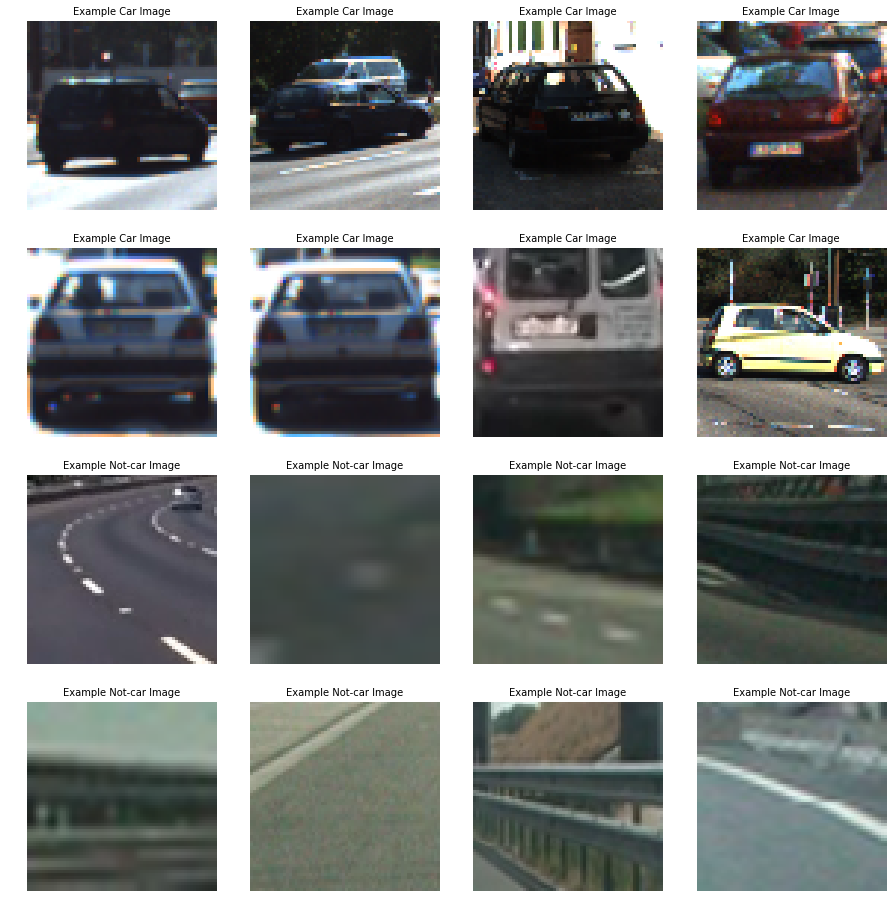

In [3]:
fig, axs = plt.subplots(4,4, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(8):
    img = cv2.imread(cars[np.random.randint(0,len(cars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Example Car Image', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(8,16):
    img = cv2.imread(notcars[np.random.randint(0,len(notcars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Example Not-car Image', fontsize=10)
    axs[i].imshow(img)

## 3. HOG features and visualization

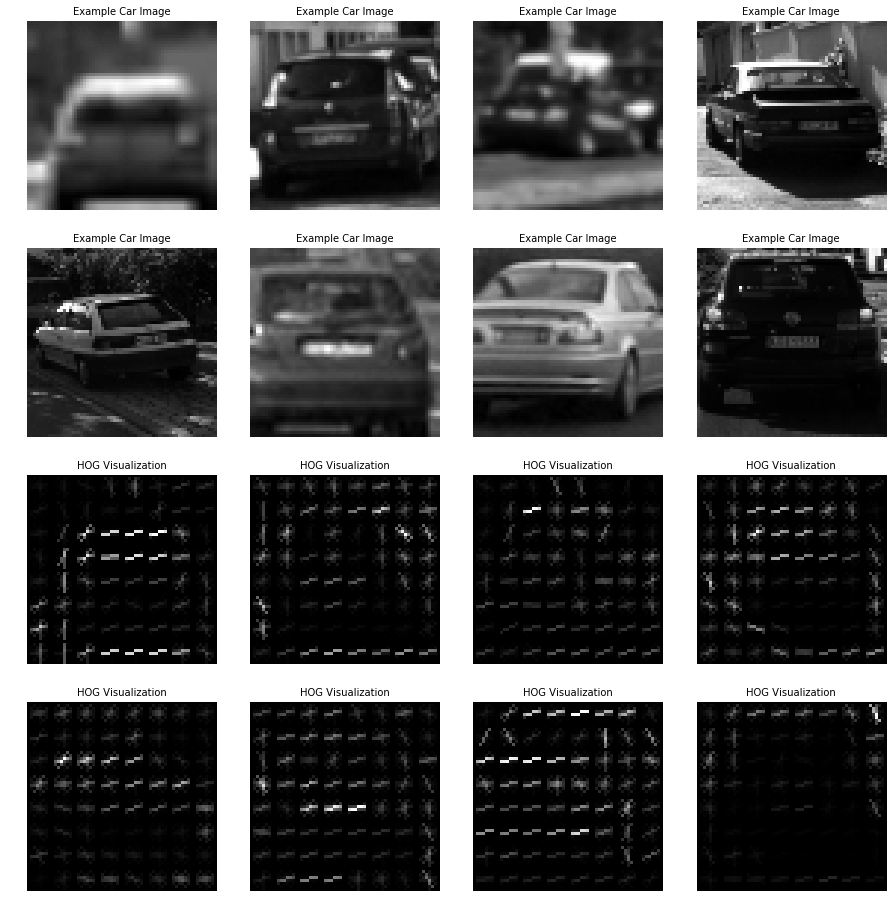

In [4]:
fig, axs = plt.subplots(4,4, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Step through the list and search for chessboard corners
for i in np.arange(8):
    img = cv2.imread(cars[np.random.randint(0,len(cars))])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    axs[i].axis('off')
    axs[i].set_title('Example Car Image', fontsize=10)
    axs[i].imshow(gray, cmap='gray')
    
    # Call our function with vis=True to see an image output
    _, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block,vis=True, feature_vec=False)
    
    axs[i+8].axis('off')
    axs[i+8].set_title('HOG Visualization', fontsize=10)
    axs[i+8].imshow(hog_image, cmap='gray')

## 4. Compute Color Histogram features and visualize the results

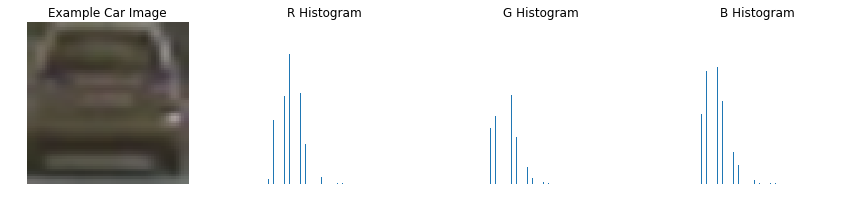

In [5]:
car_image = cv2.imread(cars[10])
rh, gh, bh, bincen = color_hist(car_image, nbins=32, bins_range=(0, 256), vis=True)

# Plot a figure with all three bar charts
if rh is not None:
    fig, axs = plt.subplots(4,1, figsize=(12, 3))
    plt.subplot(141)
    plt.imshow(car_image)
    plt.title('Example Car Image')
    plt.axis('off')
    plt.subplot(142)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.axis('off')
    plt.subplot(143)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.axis('off')
    plt.subplot(144)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    plt.axis('off')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

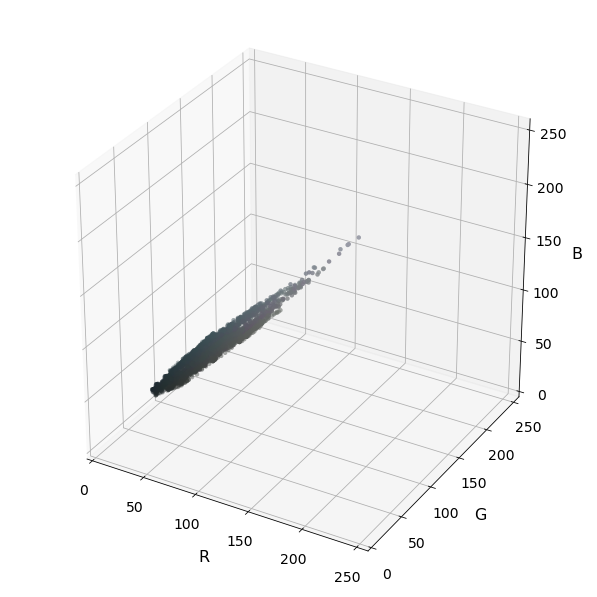

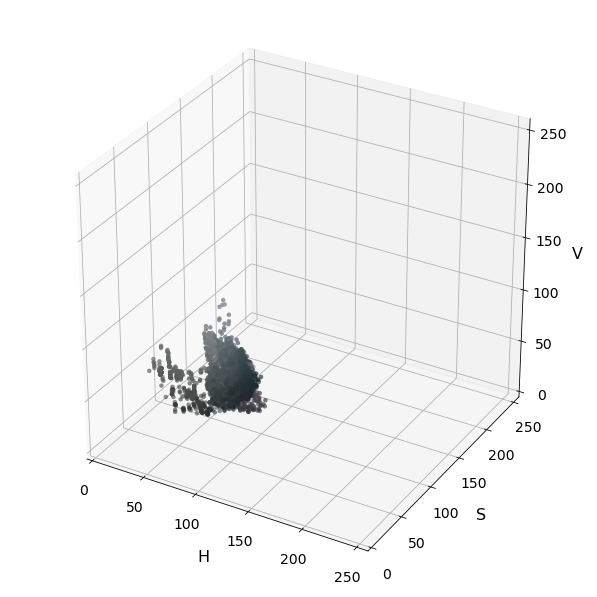

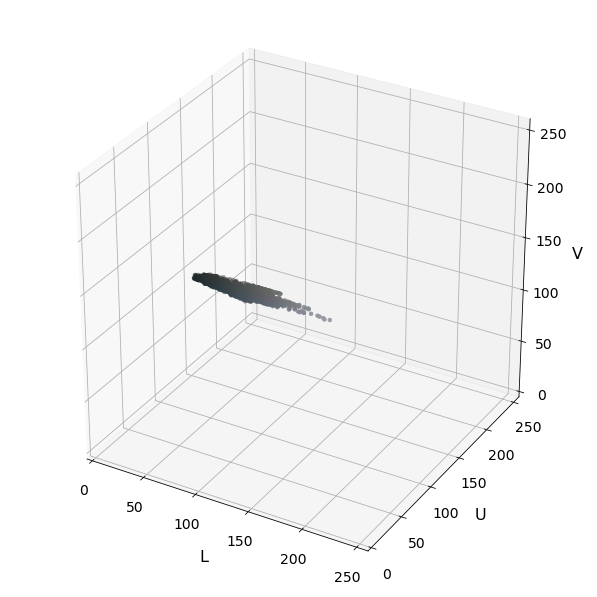

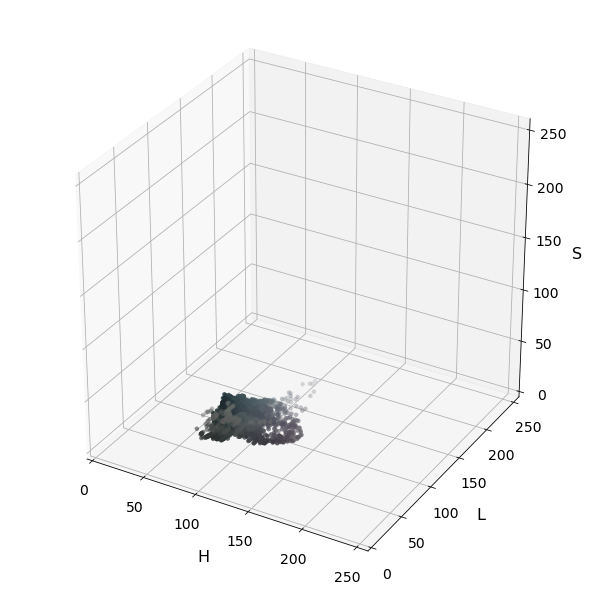

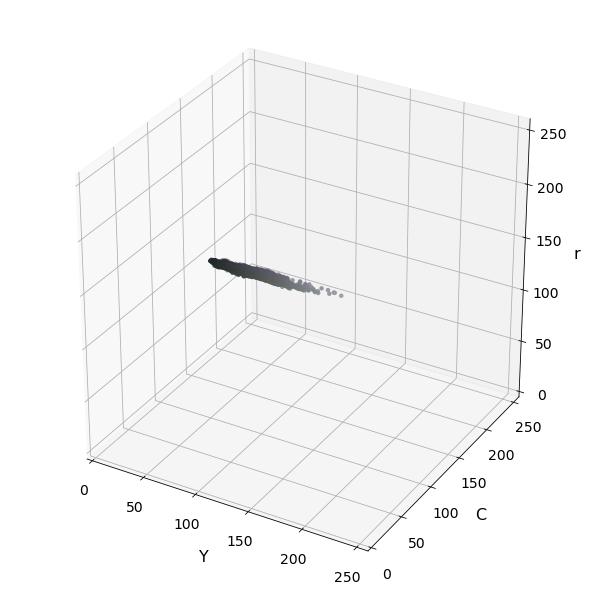

In [6]:
# Select a small fraction of pixels to plot by subsampling it
scale = max(car_image.shape[0], car_image.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(car_image, (np.int(car_image.shape[1] / scale), np.int(car_image.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
img_small_YCrCb = cv2.cvtColor(img_small, cv2.COLOR_BGR2YCrCb)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb, axis_labels=list("RGB"))
plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
plot3d(img_small_YCrCb, img_small_rgb, axis_labels=list("YCrCb"))
plt.show()

## 5. Spatial Binning of Color features and visualize the results

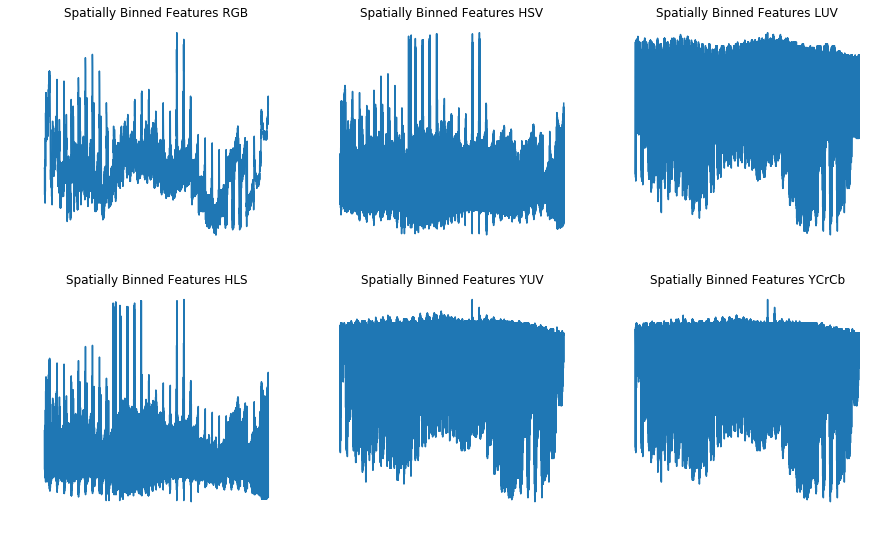

In [7]:
fig = plt.figure(figsize=(15,9))

feature_vec = bin_spatial(car_image, color_space = 'RGB', size=(32, 32))
plt.subplot(231)
plt.plot(feature_vec) # Plot features
plt.title('Spatially Binned Features RGB')
plt.axis('off')

feature_vec = bin_spatial(car_image, color_space = 'HSV', size=(32, 32))
plt.subplot(232)
plt.plot(feature_vec) # Plot features
plt.title('Spatially Binned Features HSV')
plt.axis('off')

feature_vec = bin_spatial(car_image, color_space = 'LUV', size=(32, 32))
plt.subplot(233)
plt.plot(feature_vec) # Plot features
plt.title('Spatially Binned Features LUV')
plt.axis('off')

feature_vec = bin_spatial(car_image, color_space = 'HLS', size=(32, 32))
plt.subplot(234)
plt.plot(feature_vec) # Plot features
plt.title('Spatially Binned Features HLS')
plt.axis('off')

feature_vec = bin_spatial(car_image, color_space = 'YUV', size=(32, 32))
plt.subplot(235)
plt.plot(feature_vec) # Plot features
plt.title('Spatially Binned Features YUV')
plt.axis('off')

feature_vec = bin_spatial(car_image, color_space = 'YCrCb', size=(32, 32))
plt.subplot(236)
plt.plot(feature_vec) # Plot features
plt.title('Spatially Binned Features YCrCb')
plt.axis('off')
plt.show()

## 6. Training and testing the HOG Support Vector Classifier

In [8]:
car_features = extract_features(cars, hog_feat=True)
notcar_features = extract_features(notcars, hog_feat=True)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train SVC.')
print('Using:', orient, 'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8968/8968 [00:38<00:00, 257.41it/s]


61.69 seconds to train SVC.
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932


In [9]:
print('Test Accuracy of SVC: {0:.2f}%'.format(round(svc.score(X_test, y_test)*100, 4)))
print()
t = time.time()
print('  Predictions:', svc.predict(X_test[0:10]))
print('       Labels:', y_test[0:10])
t2 = time.time()
print()
print(round(t2-t, 5), 'seconds to predict 10 labels with SVC.')

Test Accuracy of SVC: 97.16%

  Predictions: [ 1.  0.  1.  1.  1.  1.  1.  0.  0.  0.]
       Labels: [ 1.  0.  1.  1.  1.  1.  0.  0.  0.  0.]

0.02001 seconds to predict 10 labels with SVC.


## 7. Training and testing the Color Histogram Support Vector Classifier

In [10]:
car_features = extract_features(cars, spatial_feat=True, hist_feat=True)
notcar_features = extract_features(notcars, spatial_feat=True, hist_feat=True)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train SVC.')
print('Using:', orient, 'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8968/8968 [00:35<00:00, 250.36it/s]


40.33 seconds to train SVC.
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932


In [11]:
print('Test Accuracy of SVC: {0:.2f}%'.format(round(svc.score(X_test, y_test)*100, 4)))
print()
t = time.time()
print('  Predictions:', svc.predict(X_test[0:10]))
print('       Labels:', y_test[0:10])
t2 = time.time()
print()
print(round(t2-t, 5), 'seconds to predict 10 labels with SVC.')

Test Accuracy of SVC: 97.04%

  Predictions: [ 1.  0.  1.  1.  1.  1.  0.  0.  1.  0.]
       Labels: [ 1.  0.  1.  1.  1.  1.  0.  0.  1.  0.]

0.02051 seconds to predict 10 labels with SVC.


## 8. Sliding Window

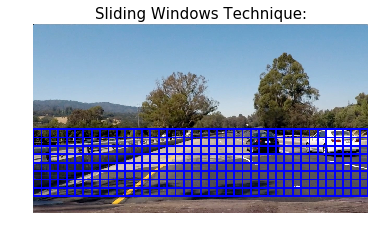

In [12]:
test_img = mpimg.imread('test_images/test4.jpg')

windows =  slide_window(test_img, x_start_stop=[None, None], y_start_stop=[400, 656], xy_window=(64, 64), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(test_img, windows)
plt.imshow(window_img);
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
plt.title('Sliding Windows Technique:', fontsize=15);
plt.savefig('output_images/sliding_windows.png', bbox_inches="tight")
plt.axis('off')
plt.show()

## 9. Train the classifier and test the predictions

In [13]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb'     # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10               # HOG orientations
pix_per_cell = 8          # HOG pixels per cell
cell_per_block = 2        # HOG cells per block
hog_channel = 'ALL'       # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)   # Spatial binning dimensions
hist_bins = 64            # Number of histogram bins
spatial_feat = True       # Spatial features on or off
hist_feat = True          # Histogram features on or off
hog_feat = True           # HOG features on or off

car_features = extract_features(cars, cspace=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, cspace=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                                   orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8968/8968 [01:52<00:00, 79.44it/s]


In [14]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
#rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations,',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = {0:.2f}%'.format(round(svc.score(X_test, y_test)*100, 4)))
# Check the prediction time for a single sample
t=time.time()

Using: 10 orientations, 8 pixels per cell and 2 cells per block
Feature vector length: 9144
17.55 Seconds to train SVC...
Test Accuracy of SVC = 99.04%


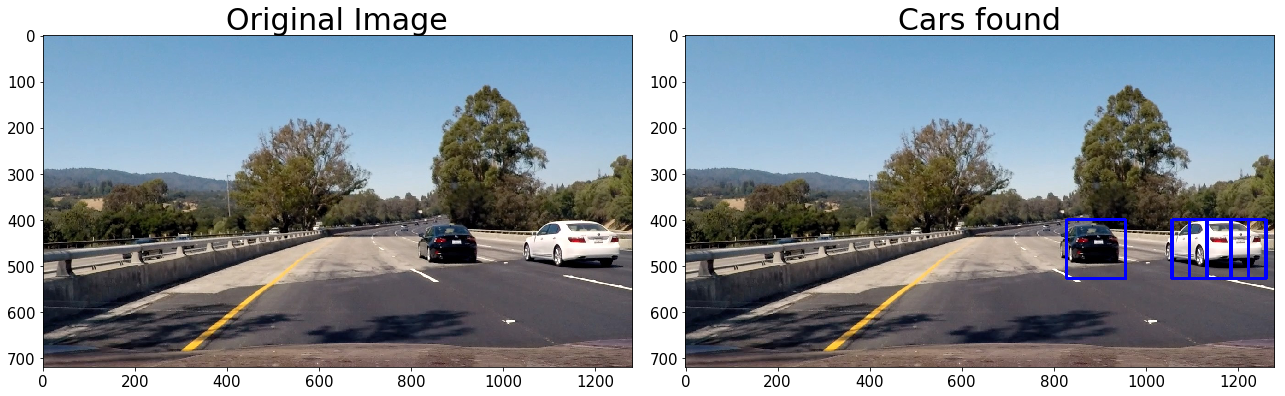

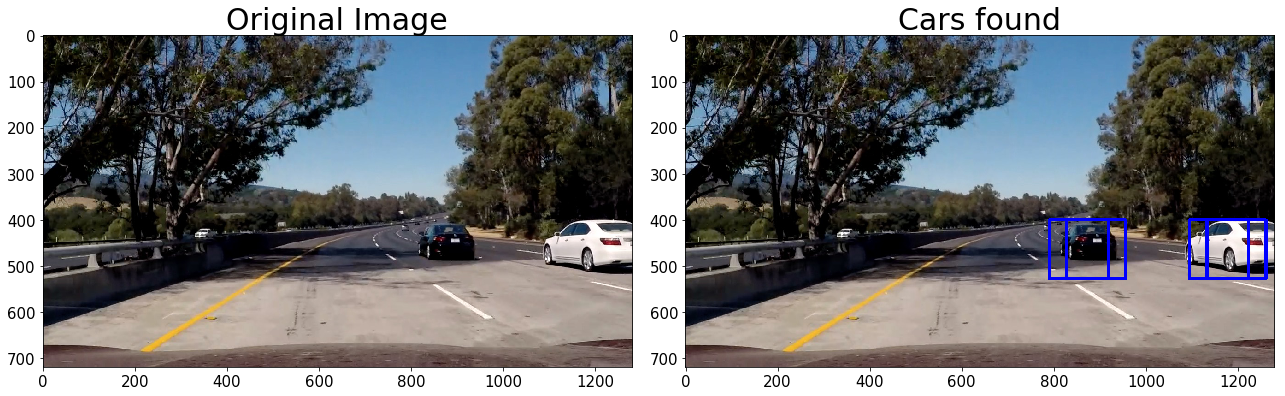

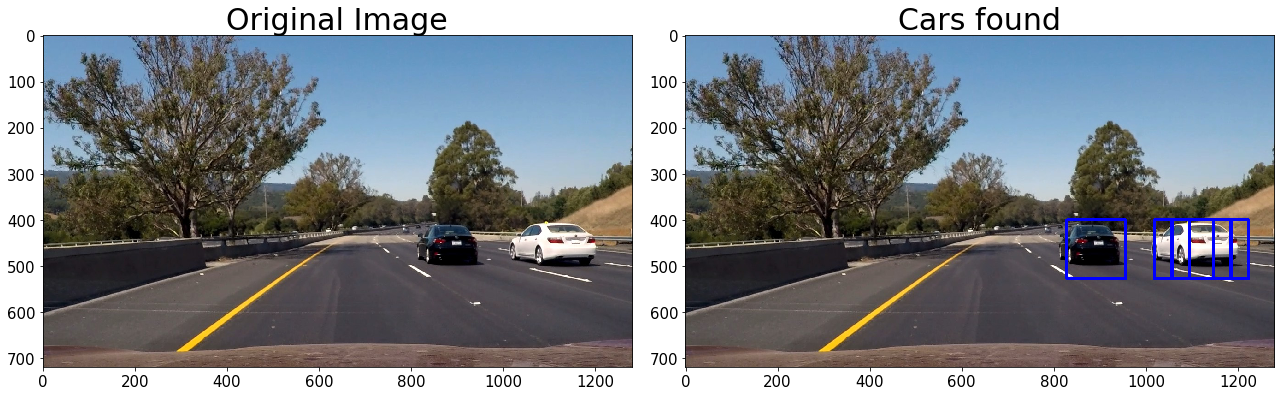

In [15]:
for i in range(4,7):
    
    fname = 'test_images/test{}.jpg'.format(i)
    image = mpimg.imread(fname)
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    windows =  slide_window(test_img, x_start_stop=[600, None], y_start_stop=[400, 656], xy_window=(128,128), xy_overlap=(.7,.7))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, spatial_size=spatial_size,
                                 hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows) 
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,9))
    plt.tight_layout()
    ax1.imshow(draw_image)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(window_img)
    ax2.set_title('Cars found', fontsize=30)
    plt.savefig('output_images/windows.png', bbox_inches="tight")

## 10. Adding Heatmaps and Bounding Boxes

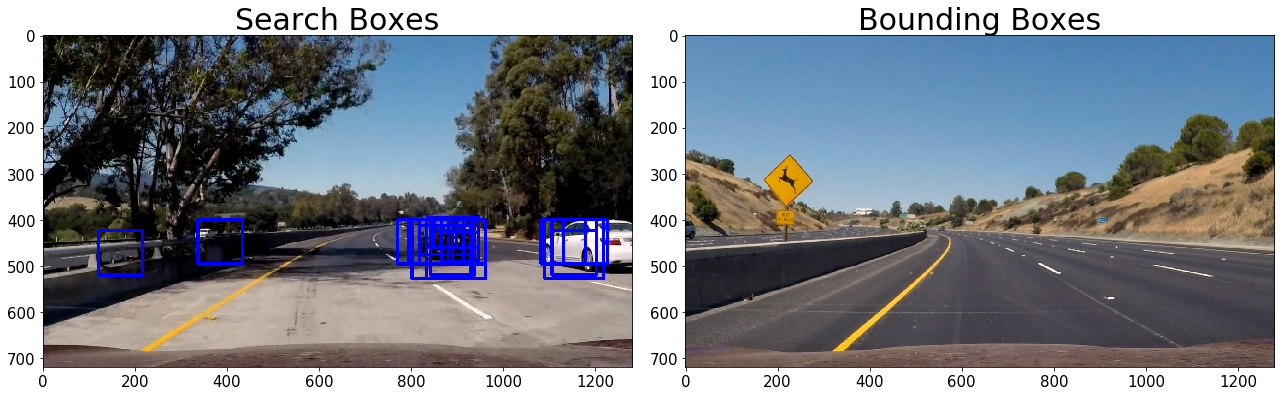

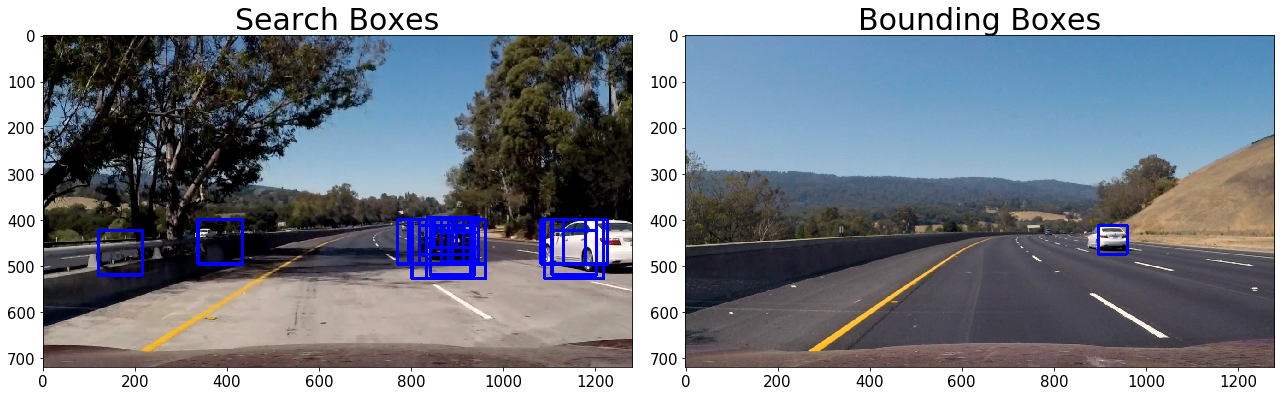

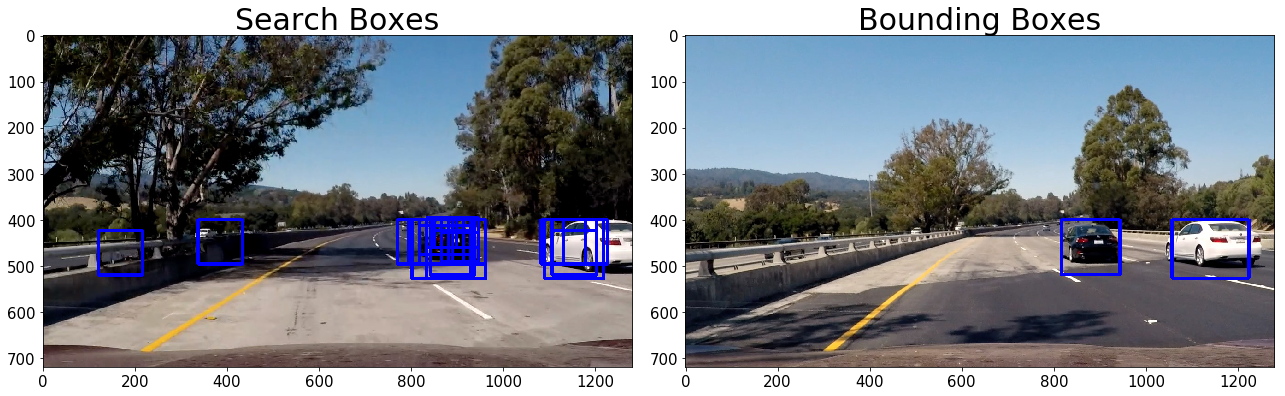

In [21]:
def process_image(img):
    orient=10
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64

    bbox_list = []

    ystart = 380
    ystop = 550
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart = 400
    ystop = 600
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart = 400
    ystop = 656
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    bbox_list = [item for sublist in bbox_list for item in sublist]

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, 2)

    # Find final boxes from heatmap using label function
    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(img), labels)

    return new_img

for i in range(2,5):
    
    fname = 'test_images/test{}.jpg'.format(i)
    img = mpimg.imread(fname)
    new_img = process_image(img)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,9))
    plt.tight_layout()
    ax1.imshow(out_img)
    ax1.set_title('Search Boxes', fontsize=30)
    ax2.imshow(new_img)
    ax2.set_title('Bounding Boxes', fontsize=30)

# Video Ouput

In [19]:
output = "project_output.mp4"
clip = VideoFileClip("project_video.mp4")
clip = clip.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [1:19:58<00:04,  4.52s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

Wall time: 1h 19min 59s
